### One. sequence determination -- XGBoost

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

figsuplix = 'pdf'

In [2]:
#############################################
def is_Exist_file(path):
    import os
    if os.path.exists(path):
        os.remove(path)


def mkdir(path):
    import os
    path = path.strip()  
    path = path.rstrip("\\")  
    isExists = os.path.exists(path)
    if not isExists:
        os.makedirs(path) 
        print(path + ' 创建成功')
    else:
        print(path + ' 目录已存在') 


def walk(path):
    import os
    input_path_list = []
    if not os.path.exists(path):
        return -1
    for root, dirs, names in os.walk(path):
        for filename in names:
            input_path = os.path.join(root, filename)
            input_path_list.append(input_path)
    return input_path_list

In [3]:
# Maximum bar width is 1. Normalise counts to be in the interval 0-1. Need to supply a maximum possible count here as maxwidth
def normaliseCounts(widths,maxwidth):
    widths = np.array(widths)/float(maxwidth)
    return widths


## note significant
def combination_list(one_list, comb_num):
    import itertools
    return list(itertools.combinations(one_list,comb_num))


def plot_note_significant(ax, plot_data, note, seq_n1, seq_n2, y, order, last_y, 
                          region, eval_algorithm):
    index_1 = order.index(seq_n1)
    index_2 = order.index(seq_n2)
    maxy = plot_data.loc[plot_data['sequence length'].isin(list(range(seq_n1, seq_n2+1, 1))), :][y].max()
    if eval_algorithm == 'BiLSTM':
        if region == 'both':
            delt_y = 0.005
            delt_note_y = 0.000
        else:
            delt_y = 0.005
            delt_note_y = 0.005
    else:
        if region == 'both':
            delt_y = 0.005
            delt_note_y = 0.005
        else:
            delt_y = 0.005
            delt_note_y = 0.005
    new_y = max([last_y + delt_y, maxy + delt_y])
    ax.hlines(new_y, index_1, index_2, colors="black")
    ax.text((index_1 + index_2)/2, new_y + delt_note_y, note, fontsize=13)
    return new_y
    


def note_significant(ax, sign_data, plot_data, region, y, order, eval_algorithm):
    if region == 'both':
        seq_list = [23, 33, 43, 53, 63]
    else:
        seq_list = [23, 24, 25, 26, 27, 28]
    import copy
    cp_seq_list = copy.deepcopy(seq_list)
    last_y = 0
    ref_l = 0
    for seq_n1 in seq_list:
        cp_seq_list.remove(seq_n1)
        if seq_n1 < ref_l:
            pass
        else:
            for seq_n2 in cp_seq_list:
                ref_l = seq_n2
                index = sign_data.loc[sign_data['combination']=='%s-%s:%s'%(region, seq_n1, seq_n2), :].index.tolist()[0]
                pvalue = sign_data.loc[index, 'p_value']
                if pvalue < 1e-10:
                    note = '**'
                    last_y = plot_note_significant(ax, plot_data, note, seq_n1, seq_n2, y, order, last_y, 
                                                   region, eval_algorithm)
                    break
                elif pvalue < 0.05:
                    note = '*'
                    last_y = plot_note_significant(ax, plot_data, note, seq_n1, seq_n2, y, order, last_y, 
                                                   region, eval_algorithm)
                    break
                else:
                    note = 'n.s.'
            if note == 'n.s.':
                last_y = plot_note_significant(ax, plot_data, note, seq_n1, seq_n2, y, order, last_y, 
                                               region, eval_algorithm)
                break
            else:
                pass
            


## plot: evaluation of XGBoost | BiLSTM on sequence determination
def plot_analysis_seq_determination(plot_data, sign_data, y, save_dir, region='both', 
                                    eval_algorithm='XGBoost', text=True):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 设置默认绘图风格
    plt.style.use("seaborn-white")  
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    if region == 'both':
        order = [23, 33, 43, 53, 63]
    elif region == 'downstream':
        order = [23, 24, 25, 26, 27, 28]
    else: # region == 'upstream':
        order = [28, 27, 26, 25, 24, 23]
    palette = {23: 'purple', 33: 'hotpink', 43: 'royalblue', 
              53: 'darkorange', 63: 'lightgreen', 
              24: 'darkorchid', 25: 'magenta', 26: 'orchid', 27: 'lightgreen', 28: 'darkorange'}
    if y == 'val spearman':
        ax = sns.boxplot(x='sequence length', y=y, data=plot_data, palette=palette, width=0.4,  
                         fliersize=0.5, linewidth=0.5, order=order, whis=[0, 100])
    else: 
        ax = sns.barplot(x='sequence length', y=y, data=plot_data, palette=palette, capsize=0.2,  
                         errwidth=0.5, order=order)
        # set these based on your column counts
        columncounts = [60]*len(order)
        widthbars = normaliseCounts(columncounts,100)
        # Loop over the bars, and adjust the width (and position, to keep the bar centred)
        for bar, newwidth in zip(ax.patches, widthbars):
            x = bar.get_x()
            width = bar.get_width()
            centre = x+width/2.
            bar.set_x(centre-newwidth/2.)
            bar.set_width(newwidth)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax1 = sns.stripplot(x='sequence length', y=y, data=plot_data, color="orange", 
                        jitter=0.1, size=1.5, order=order)
    ## xlabel, ylabel
    plt.ylabel('Spearman Coefficient', fontsize=12, weight='bold')
    plt.xlabel('Sequence length: region - %s'%(region), fontsize=12, weight='bold')
    ## xticks
    plt.xticks(range(len(order)), order, fontsize=10, weight='bold')
    ## ylim
    if eval_algorithm == 'XGBoost':
        plt.ylim(0.7, 0.90)
    else:
        plt.ylim(0.71, 0.92)
    ## note significant
    note_significant(ax, sign_data, plot_data, region, y, order, eval_algorithm)
    ## text
    if text:
        for i, seq_len in enumerate(order):
            v = plot_data.loc[plot_data['sequence length']==seq_len, :][y].median()
            plt.text(i-0.2, v+ v*0.015, round(v, 3), fontsize=10, weight='bold')
    else:
        pass
    ## title
    if y == 'val spearman':
        title = '%s for validataion datasets - %s'%(eval_algorithm, region)
    else:
        title = '%s for test datasets - %s'%(eval_algorithm, region)
    plt.title(title, fontsize=12, weight='bold')
    mkdir(save_dir)
    savefig_path = save_dir + '/%s.%s'%(title, figsuplix)
    plt.savefig(savefig_path, dpi=300, bbox_inches = 'tight')
    plt.show()

In [4]:
main_path = "../data"
os.chdir(main_path)

./pdf/on-target/Fig10-12-seq determination 创建成功


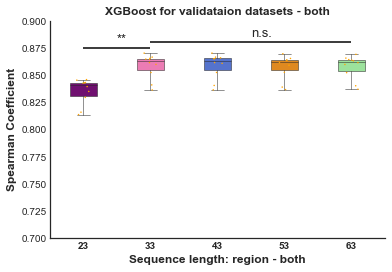

./pdf/on-target/Fig10-12-seq determination 目录已存在


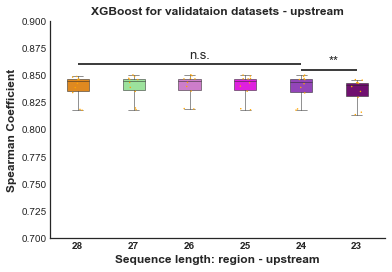

./pdf/on-target/Fig10-12-seq determination 目录已存在


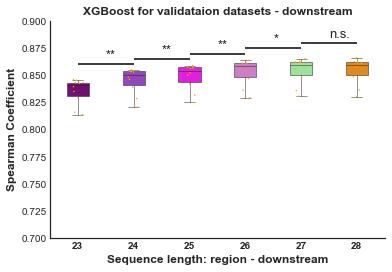

./pdf/on-target/Fig10-12-seq determination 目录已存在


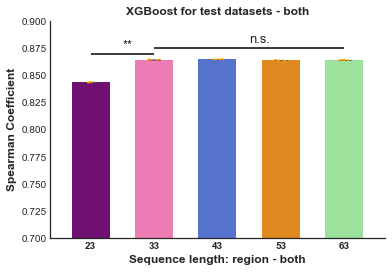

./pdf/on-target/Fig10-12-seq determination 目录已存在


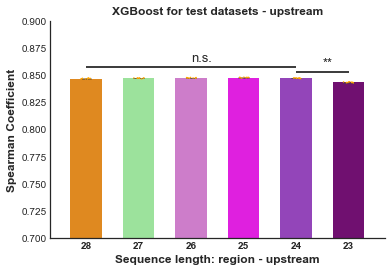

./pdf/on-target/Fig10-12-seq determination 目录已存在


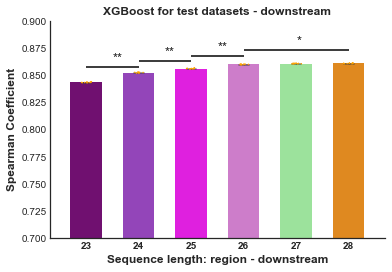

./pdf/on-target/Fig10-12-seq determination 目录已存在


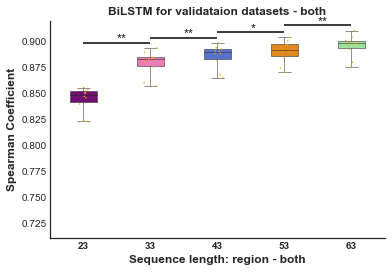

./pdf/on-target/Fig10-12-seq determination 目录已存在


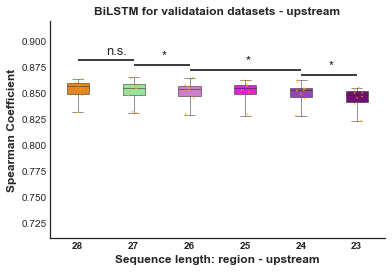

./pdf/on-target/Fig10-12-seq determination 目录已存在


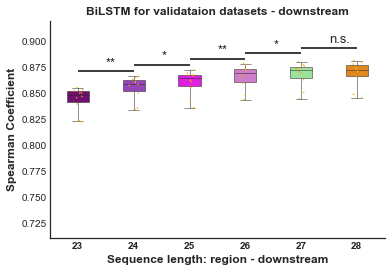

./pdf/on-target/Fig10-12-seq determination 目录已存在


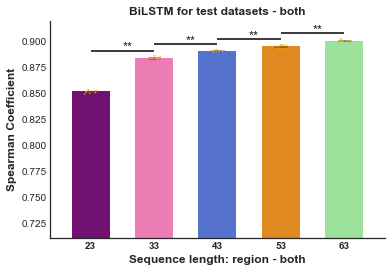

./pdf/on-target/Fig10-12-seq determination 目录已存在


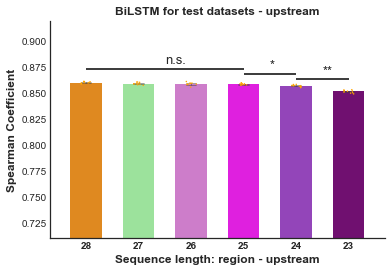

./pdf/on-target/Fig10-12-seq determination 目录已存在


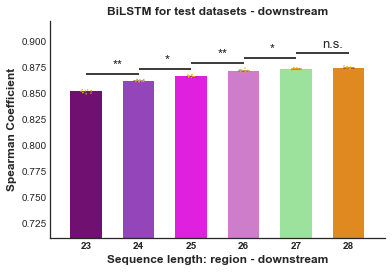

In [5]:
## execute
y = 'test spearman'
text = False
read_sign_data_dir = './On-Target/seq_determination/sign_data'
for eval_algorithm in ['XGBoost', 'BiLSTM']:
    for y in ['val spearman', 'test spearman']:
        data_path = './On-Target/seq_determination/%s_evaluation_for_sequence_determination.log'%(eval_algorithm)
        ## read sign data
        data = pd.read_csv(data_path, sep='\t')
        save_dir = './%s/on-target/Fig10-12-seq determination'%figsuplix
        for region in ['both', 'upstream', 'downstream']:
            read_sign_data_path = read_sign_data_dir + '/%s-medianp_Steiger_test-K562_%s-%s.xlsx'%(eval_algorithm, 
                                                                                               y.split(' ')[0], 
                                                                                               region)
            sign_data = pd.read_excel(read_sign_data_path)
            plot_data = data.loc[data['region']==region, :]
            plot_analysis_seq_determination(plot_data, sign_data, y, save_dir, region, eval_algorithm, text)

### Two. On-target models ten-fold cross validataion

In [6]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [7]:
## plot: ten-fold cross validation
# Maximum bar width is 1. Normalise counts to be in the interval 0-1. Need to supply a maximum possible count here as maxwidth
def normaliseCounts(widths,maxwidth):
    widths = np.array(widths)/float(maxwidth)
    return widths


## note significant
def get_note(sign_data, comb):
    index = sign_data.loc[sign_data['combination']==comb, :].index.tolist()[0]
    pvalue = sign_data.loc[index, 'p_value']
    if pvalue < 1e-5:
        note = '**'
    elif pvalue < 0.05:
        note = '*'
    else:
        note = 'n.s.'
    return note


def get_delt_ys(cell_line, note):
    if cell_line == 'K562':
        delt_y = 0.015
        delt_note_y = -0.0035
    elif cell_line == 'Jurkat':
        if note != 'n.s.':
            delt_y = 0.015
            delt_note_y = -0.0035
        else:
            delt_y = 0.02
            delt_note_y = 0.005
    else:
        delt_y = 0.05
        delt_note_y = 0.01
    return (delt_y, delt_note_y)
    
    
def note_significant_for_comparison(ax, sign_data, plot_data, order, cell_line):
    comb_list = [('BiLSTM', 'CNN'), ('BiLSTM', 'XGBoost'), ('CNN', 'XGBoost')]
    last_y = 0
    for model1, model2 in comb_list[:-1]:
        comb = '%s vs %s'%(model1, model2)
        note = get_note(sign_data, comb)
        delt_y, delt_note_y = get_delt_ys(cell_line, note)
        ## note
        index1 = order.index(model1)
        index2 = order.index(model2)
        max_y = plot_data.loc[plot_data['model label'].isin([model1, model2]), y].max()
        last_y = max([last_y + delt_y, max_y + delt_y])
        if 'CNN' in [model1, model2]:
            pass
            ax.hlines(last_y, index1, index2-0.05, colors="black")
            ax.text((index1 + index2)/2, last_y + delt_note_y, note, fontsize=13)
        else:
            ax.hlines(last_y, index1, index2, colors="black")
            ax.text((index1 + index2)/2, last_y + delt_note_y, note, fontsize=13)
    ## for ('CNN', 'XGBoost')
    model1, model2 = ('CNN', 'XGBoost')
    comb = '%s vs %s'%(model1, model2)
    ## note
    note = get_note(sign_data, comb)
    delt_y, delt_note_y = get_delt_ys(cell_line, note)
    index1 = order.index(model1)
    index2 = order.index(model2)
    max_y = plot_data.loc[plot_data['model label'].isin([model1, model2]), y].max() + delt_y
    ax.hlines(max_y, index1+0.05, index2, colors="black")
    ax.text((index1 + index2)/2, max_y + delt_note_y, note, fontsize=13)


def plot_on_target_CrossValidation(cell_line, plot_data, sign_data, y, save_dir, text=True):
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use("seaborn-white")  
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    palette = {'BiLSTM': 'purple', 'CNN': 'hotpink', 'XGBoost': 'royalblue', 
              'MLP': 'darkorange', 'Random_Forest': 'lightgreen', 
              'Elastic': 'darkorchid', 'Ridge': 'magenta', 'Lasso': 'orchid', 'GBDT': 'turquoise'}
    order = ['BiLSTM', 'CNN', 'XGBoost', 'GBDT', 'MLP', 'Random_Forest', 'Elastic', 'Ridge', 'Lasso']
    ax = sns.boxplot(x='model label', y=y, data=plot_data, palette=palette, width=0.4,  
                     fliersize=0.5, linewidth=0.5, order=order, whis=[0, 100])
    ## 坐标轴不可见
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax1 = sns.stripplot(x='model label', y=y, data=plot_data, color="orange", 
                        jitter=0.01, size=1.5, order=order)
    ## xlabel, ylabel
    plt.ylabel('Spearman Coefficient', fontsize=12, weight='bold')
    plt.xlabel('Algorithm comparison', fontsize=12, weight='bold')
    ## xticks 
    plt.xticks(range(len(order)), order, fontsize=10, weight='bold', rotation=45)
    ## text 
    note_significant_for_comparison(ax, sign_data, plot_data, order, cell_line)
    if text:
        for i, model_label in enumerate(order):
            maxv = plot_data.loc[plot_data['model label']==model_label, y].max()
            v = plot_data.loc[plot_data['model label']==model_label, y].median()
            plt.text(i-0.2, maxv+maxv*0.01, round(v, 3), fontsize=10, weight='bold')
    else:
        pass 
    ## ylim 
    if cell_line == 'H1':
        plt.ylim(0., 0.8)
    elif cell_line == 'Jurkat':
        plt.ylim(0.6, 0.95)
    else:
        plt.ylim(0.6, 0.95)
    ## title
    if y == 'val spearman':
        title = 'For validataion datasets - %s'%(cell_line)
    else:
        title = 'For test datasets - %s'%(cell_line)
    plt.title(title, fontsize=12, weight='bold')
    mkdir(save_dir)
    savefig_path = save_dir + '/%s.%s'%(title, figsuplix)
    plt.savefig(savefig_path, dpi=300, bbox_inches = 'tight')
    plt.show()

./pdf/on-target/Fig13-model evaluation 创建成功


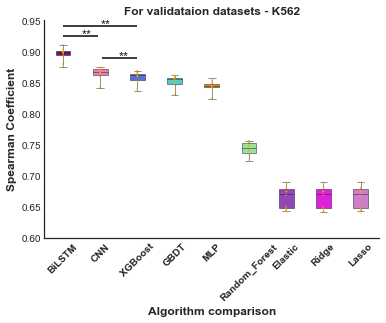

./pdf/on-target/Fig13-model evaluation 目录已存在


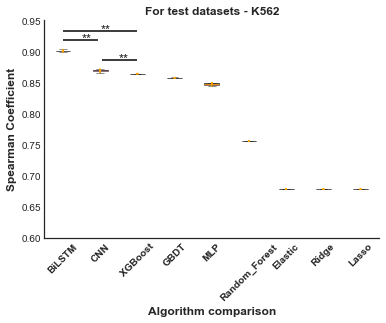

./pdf/on-target/Fig13-model evaluation 目录已存在


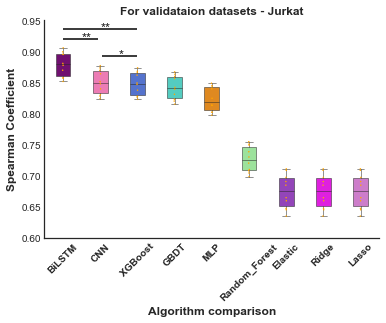

./pdf/on-target/Fig13-model evaluation 目录已存在


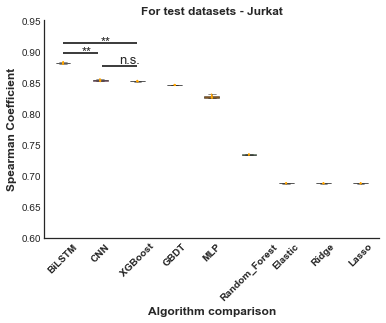

In [8]:
## execute
text = False
sign_data_dir = './On-Target/model_evaluation/sign_data'
for cell_line in ['K562', 'Jurkat']:
    data_path = './On-Target/model_evaluation/algorithms_comparison_for_%s.log'%(cell_line)
    for y in ['val spearman', 'test spearman']:
        sign_data_path = sign_data_dir + '/%s-%s-medianp_Steiger_test.xlsx'%(cell_line, y.split(' ')[0])
        sign_data = pd.read_excel(sign_data_path)
        plot_data = pd.read_csv(data_path, sep='\t')
        save_dir = './%s/on-target/Fig13-model evaluation'%figsuplix
        plot_on_target_CrossValidation(cell_line, plot_data, sign_data, y, save_dir, text)

### Three. compration performance across cell lines

In [9]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [10]:
## For Final models between K562, Jurkat and H1
## note significant
def get_note_2(sign_data, comb):
    index = sign_data.loc[sign_data['combination']==comb, :].index.tolist()[0]
    pvalue = sign_data.loc[index, 'p_value']
    if pvalue < 1e-10:
        note = '**'
    elif pvalue < 0.05:
        note = '*'
    else:
        note = 'n.s.'
    return note


def get_model_combination(cell_line):
    if cell_line == 'K562':
        model_comb_list = [('K562', 'Jurkat')]
    elif cell_line == 'Jurkat':
        model_comb_list = [('Jurkat', 'K562')]
    return model_comb_list



## note significant
def note_significant_for_cross_evaluation(ax, sign_data_dir, stat_data, order, for_cross_val=True):
    delt = 0.3
    delt_y = 0.04
    delt_note_y = -0.0
    last_y = 0.
    for index, cell_line in enumerate(order):
        if for_cross_val:
            sign_data_path = sign_data_dir + '/%s-medianp_Steiger_test-for_cross_validation.xlsx'%(cell_line)
        else:
            sign_data_path = sign_data_dir + '/%s-finalp_Steiger_test-for_cross_validation.xlsx'%(cell_line)
        sign_data = pd.read_excel(sign_data_path)
        model_comb_list = get_model_combination(cell_line)
        for model1, model2 in model_comb_list:
            i1, i2 = order.index(model1), order.index(model2)
            transform = {0: -delt, 1: delt}
            ix1, ix2 = index + transform[i1], index + transform[i2]
            maxy = stat_data.loc[(stat_data['test data']==cell_line) & (stat_data['model'].isin([model1, model2])), 'spearman'].max()
            last_y = max([last_y + delt_y, maxy + delt_y])
            ## get note 
            comb = '%s vs %s'%(model1, model2)
            note = get_note_2(sign_data, comb)
            ax.hlines(last_y, ix1, ix2, colors="black")
            ax.text((ix1 + ix2)/2, last_y + delt_note_y, note, fontsize=13)
        last_y = 0


def barplot_cross_evaluation_across_cells(stat_data, save_dir, sign_data_dir, text=True, for_cross_val=False):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(1,1, figsize=(4, 6))
    fig.subplots_adjust(wspace=5)
    
    palette = {'K562': 'purple', 'Jurkat': 'royalblue', 'H1': 'lightseagreen'}
    sns.barplot(x='test data', y='spearman', hue='model', data=stat_data, palette=palette)
    ## 坐标轴不可见 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ## ylim  
    plt.ylim(0, 1.05) 
    plt.ylabel('Spearman Coefficient', fontsize=12, weight='bold')
    plt.xlabel('Test Dataset', fontsize=12, weight='bold')
    plt.xticks(fontsize=10, weight='bold')
    ## text
    test_data_list = ['K562', 'Jurkat']
    cell_n = len(test_data_list)
    if text:
        for i in range(cell_n):
            sp = stat_data.loc[i, 'spearman']
            plt.text(-0.3 + 0.4*i, sp+sp*0.01, round(sp, 3), fontsize=8, weight='bold')
        for i in range(cell_n):
            sp = stat_data.loc[i+cell_n, 'spearman']
            plt.text(0.7 + 0.4*i, sp+sp*0.01, round(sp, 3), fontsize=8, weight='bold')
    else:
        pass
    note_significant_for_cross_evaluation(ax, sign_data_dir, stat_data, test_data_list, for_cross_val)
    ## title
    title = 'comparison predictions across cell lines for each final model'
    mkdir(save_dir)
    savefig_path = save_dir + '/%s.%s'%(title, figsuplix)
    plt.legend(loc='best')
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(0.4,1.05), loc=2, borderaxespad=0.)
    plt.savefig(savefig_path, dpi=300, bbox_inches = 'tight')
    plt.show()

./pdf/on-target/Fig16-cross evaluation 创建成功


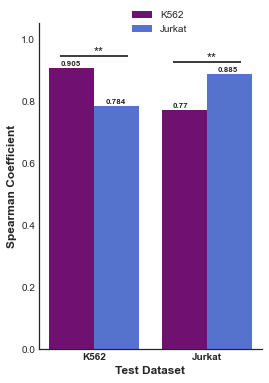

In [11]:
##  execute for final

stat_data_path = './On-Target/model_evaluation/cross_evaluation/cross_evaluation_across_cells_for_on_target_final_model.xlsx'
sign_data_dir = './On-Target/model_evaluation/cross_evaluation/'
save_dir = './%s/on-target/Fig16-cross evaluation'%figsuplix
stat_data = pd.read_excel(stat_data_path)
stat_data = stat_data.loc[(stat_data['test data']!='H1') & (stat_data['model']!='H1'), :]
stat_data.reset_index(drop=True, inplace=True)
text = True
for_cross_val = False
barplot_cross_evaluation_across_cells(stat_data, save_dir, sign_data_dir, text, for_cross_val)

### Evaluation for public dataset (CRISPOR)

In [12]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [13]:
## heatmap for comparation between models
def update_dataset_label(data, update_dataset_dict):
    data['dataset'] = data.index
    data['dataset'] = data['dataset'].apply(lambda x: update_dataset_dict[x] if x in update_dataset_dict else x)
    data.index = data['dataset']
    del data['dataset']
    return data
    
    
## get heatmap data
def obtain_heatmap_data_for_models_comparison(cmp_data, parts_dataset_dict, selective_models_for_comparison,
                                              note_dataset_taining_model, update_dataset_dict, 
                                              cell_line=False):
    keep_datasets_for_comparison = []
    for dataset_list in parts_dataset_dict.values():
        keep_datasets_for_comparison += dataset_list
    
    ## index 赋值
    cmp_data.index = cmp_data.Dataset
    ## 选择比较的数据集 & 选择比较的算法
    cmp_data = cmp_data.loc[keep_datasets_for_comparison,:]
    cmp_data = cmp_data[selective_models_for_comparison]
    ## 把 Xu_Hl60_2015(2076) & XU_Kbm7_2015(2076) 评估结果取正 
    ## 对行操作
    try: 
        if cell_line == 'K562':
            cmp_data['Xu_Hl60_2015(1774)':'Xu_Hl60_2015(1774)'] = abs(cmp_data['Xu_Hl60_2015(1774)':'Xu_Hl60_2015(1774)'])
        elif cell_line == 'Jurkat':
            cmp_data['Xu_Hl60_2015(1776)':'Xu_Hl60_2015(1776)'] = abs(cmp_data['Xu_Hl60_2015(1776)':'Xu_Hl60_2015(1776)'])
        elif cell_line == 'H1':
            cmp_data['Xu_Hl60_2015(2026)':'Xu_Hl60_2015(2026)'] = abs(cmp_data['Xu_Hl60_2015(2026)':'Xu_Hl60_2015(2026)'])
        else:
            cmp_data['Xu_Hl60_2015(2076)':'Xu_Hl60_2015(2076)'] = abs(cmp_data['Xu_Hl60_2015(2076)':'Xu_Hl60_2015(2076)'])
    except KeyError as e:
        pass
    try: 
        if cell_line == 'K562':
            cmp_data['XU_Kbm7_2015(1774)':'XU_Kbm7_2015(1774)'] = abs(cmp_data['XU_Kbm7_2015(1774)':'XU_Kbm7_2015(1774)'])
        elif cell_line == 'Jurkat':
            cmp_data['XU_Kbm7_2015(1776)':'XU_Kbm7_2015(1776)'] = abs(cmp_data['XU_Kbm7_2015(1776)':'XU_Kbm7_2015(1776)'])
        elif cell_line == 'H1':
            cmp_data['XU_Kbm7_2015(2026)':'XU_Kbm7_2015(2026)'] = abs(cmp_data['XU_Kbm7_2015(2026)':'XU_Kbm7_2015(2026)'])
        else:
            cmp_data['XU_Kbm7_2015(2076)':'XU_Kbm7_2015(2076)'] = abs(cmp_data['XU_Kbm7_2015(2076)':'XU_Kbm7_2015(2076)'])
    except KeyError as e:
        pass
    ## for mask paired with cmp_data
    import copy
    paired_cmp_data = copy.deepcopy(cmp_data)
    paired_cmp_data.loc[:,:] = 0
    # show each model own training dataset
    for model_col, dataset_row_list in note_dataset_taining_model.items():
        for dataset_row in dataset_row_list:
            paired_cmp_data.loc[dataset_row, model_col] = 1.
    ## datasets split three parts: U6, T7 & small datasets
    paired_heatmap_data_dict = {}
    for dataset_label, dataset_list in parts_dataset_dict.items():
        part_cmp_data = cmp_data.loc[dataset_list, :]
        part_paried_cmp_data = paired_cmp_data.loc[dataset_list, :]
        ## update datset 
        part_cmp_data = update_dataset_label(part_cmp_data, update_dataset_dict)
        part_paried_cmp_data = update_dataset_label(part_paried_cmp_data, update_dataset_dict)
        paired_heatmap_data_dict[dataset_label] = (part_cmp_data, part_paried_cmp_data)
    ## all
    paired_heatmap_data_dict['All'] = (cmp_data, paired_cmp_data)
    ## update datset 
    cmp_data = update_dataset_label(cmp_data, update_dataset_dict)
    paired_cmp_data = update_dataset_label(paired_cmp_data, update_dataset_dict)
    return paired_heatmap_data_dict
        


## plot heatmap
def plot_single_heatmap_for_comparison(data, mask_data, model_list, 
                                         title, savefig_path, vmax=0.67, figsize=(10,5), cmap='coolwarm'):
    import seaborn as sns; sns.set()
    from matplotlib import pyplot as plt

    data = data[model_list]
    mask_data = mask_data[model_list]
    
    sns.set_style("darkgrid")
    f, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(data, mask=np.array(mask_data), cbar=True, cmap=cmap, vmax=vmax,
                     linewidths=0.01)

    ## text
    cols = data.columns.tolist()
    total_row_num = len(data)
    row_num = -1
    for index, row in data.iterrows():
        row_num += 1
        for index, col in enumerate(cols):
            plt.text(index+0.25, row_num+0.5, str(round(row[col], 3)))
    plt.title(title)
    plt.savefig(savefig_path, dpi=300, bbox_inches = 'tight')
    plt.show()
################################################################

In [14]:
## note significant
################################################################
def get_note_for_cripsor(sign_data, dataset):
    try:
        index = sign_data.loc[sign_data['Dataset']==dataset, :].index.tolist()[0]
    except IndexError as e:
        print("dataset:", dataset)
        raise(e)
    p_value = sign_data.loc[index, 'p_value']
    if p_value < 1e-5:
        note = '***'
    elif p_value < 1e-3:
        note = '**'
    elif p_value < 0.05:
        note = '*'
    else:
        note = 'n.s.'
    return note


def note_significant_for_crispor(ax, data, sign_data):
    x = 0.7
    dataset_list = data.index.tolist()
    for i, dataset in enumerate(dataset_list):
        note = get_note_for_cripsor(sign_data, dataset)
        # ax.hlines(last_y, ix1, ix2, colors="black")
        ax.text(x, i+0.9, note, fontsize=10)


## plot heatmap
def plot_single_heatmap_for_comparison_adding_note_significant(data, mask_data, model_list, 
                                                               title, savefig_path, sign_data, 
                                                               vmax=0.67, figsize=(10,5), cmap='coolwarm'):
    import seaborn as sns; sns.set()
    from matplotlib import pyplot as plt

    data = data[model_list]
    mask_data = mask_data[model_list]
    
    sns.set_style("darkgrid")
    f, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(data, mask=np.array(mask_data), cbar=True, cmap=cmap, vmax=vmax,
                     linewidths=0.01)

    ## text
    cols = data.columns.tolist()
    total_row_num = len(data)
    row_num = -1
    for index, row in data.iterrows():
        row_num += 1
        for index, col in enumerate(cols):
            plt.text(index+0.25, row_num+0.5, str(round(row[col], 3)))
    ## note significant
    note_significant_for_crispor(ax, data, sign_data)
    plt.title(title)
    plt.savefig(savefig_path, dpi=300, bbox_inches = 'tight')
    plt.show()
################################################################

###### excluding our training gRNAs for CRISPOR dataset

In [15]:
## For K562 filtered crispor
## fix it fot mask data
## show each model own training dataset
note_dataset_taining_model_k562 = {'ChariRank': ['Chari_293T_2015(916)'], # From DeepHF & CRISPOR & DeepSpCas9
                            'CRISPR scan': ['Moreno-Mateos_Zebrafish_2015(1020)'], # From DeepHF & CRISPOR & DeepSpCas9
                            'Doench score(2014)': ['Doench_Mouse-El4_2014(951)', 'Doench_Hs_2014(842)'], # From DeepHF & CRISPOR & DeepSpCas9
                            'Doench score(2016)': ['Doench_Mouse-El4_2014(951)', 'Doench_Hs_2014(842)', 
                                                   'Doench_Hg19_2016(2236)'], # From DeepHF & CRISPOR & DeepSpCas9
                            'Xu score': ['Xu_Hl60_2015(1774)', 'XU_Kbm7_2015(1774)'], # From DeepHF & CRISPOR
                            'Wang score': ['Xu_Hl60_2015(1774)', 'XU_Kbm7_2015(1774)'], # From DeepHF & CRISPOR
                            'DeepCRISPR': ['Hart_Hela_Lib1_2016(3381)', 'Hart_Hct116_Lib1_2016(3364)', 
                                           'Hart_Hela_Lib2_2016(3355)', 'Hart_Rpel_2016(3351)', 
                                           'Doench_Hg19_2016(2236)', 
                                           'Xu_Hl60_2015(1774)', 'XU_Kbm7_2015(1774)'], # From DeeHF 
                            'DeepWt_U6': ['Xu_Hl60_2015(1774)', 'XU_Kbm7_2015(1774)'], # From DeepHF
                            'DeepWt_T7': ['Moreno-Mateos_Zebrafish_2015(1020)']} # From DeepHF
    
    
## 用于比较的內源数据集：U6、T7 and small datasets
u6_datasets_for_comparison_k562 = ['Hart_Hela_Lib1_2016(3381)', 
                                    'Hart_Hct116_Lib1_2016(3364)', 
                                    'Hart_Rpel_2016(3351)', 
                                    'Hart_Hela_Lib2_2016(3355)', 
                                    'Doench_Hg19_2016(2236)', 
                                    'Xu_Hl60_2015(1774)', 
                                    'XU_Kbm7_2015(1774)', 
                                    'Chari_293T_2015(916)', 
                                    'Doench_Mouse-El4_2014(951)', 
                                    'Doench_Hs_2014(842)',
                                     'Endo-293T(78)', 
                                     'Endo-H1(75)', 
                                     'Endo-K562(71)']

t7_datasets_for_comparison_k562 = ['Moreno-Mateos_Zebrafish_2015(1020)', # Zebrafish
                                    'Gagnon_Zebrafish_2014(111)', # Zebrafish
                                    'Varshney_Zebrafish_2015(102)', # Zebrafish
                                    'ShkumatavaOthers_Zebrafish(84)', # Zebrafish
                                    'ShkumatavaPerrine_Zebrafish(62)', # Zebrafish
                                    'ShkumatavaAngelo_Zebrafish(17)', # Zebrafish
                                    'Teboul_Mm9_in-vivo(30)', # Mouse
                                    'Eschstruth_Zebrafish(17)'  # Zebrafish
                                  ]

small_datasets_for_comparison_k562 = [ 'Liu_Mm9_2016(203)',
                                    'Gandhi_Electrop.Ciona(72)', 
                                    'Farbound_C.elegans_2015(50)',
                                    'xu2015(33)', 
                                    'Concordet2-Hs(20)', 
                                    'Xu_AAVS1_2015(20)', 
                                    'Concordet2_Mm(18)', 
                                    'Xu_FOX-AR_2015(13)', 
                                    'SchoenigRn(15)'
    #                                 'SchoenigHs(3)'
                                     ]

## 更新数据集名称
update_dataset_dict_k562 = {"Hart_Hela_Lib1_2016(3381)": "Hart 2016 HeLa-Lib1 (3381)",
                         "Hart_Hct116_Lib1_2016(3364)": "Hart 2016 HCT116-Lib1 (3364)", 
                         "Hart_Rpel_2016(3351)": "Hart 2016 RPE (3351)", 
                         "Hart_Hela_Lib2_2016(3355)": "Hart 2016 HeLa-Lib2 (3355)", 
                         "Doench_Hg19_2016(2236)": "Doench 2016 A375 (2236)", 
                         "Xu_Hl60_2015(1774)": "Xu 2015 HL60 (1774)", 
                         "XU_Kbm7_2015(1774)": "Xu 2015 KBM7 (1774)", 
                         "Chari_293T_2015(916)": "Chari 2015 293T (916)", 
                         "Doench_Mouse-El4_2014(951)": "Doench 2014 Mouse-EL4 (951)", 
                         "Doench_Hs_2014(842)": "Doench 2014 MOLM13 (842)"}



./pdf/on-target/Fig17-CRISPOR evaluation/filtered_crispor 创建成功


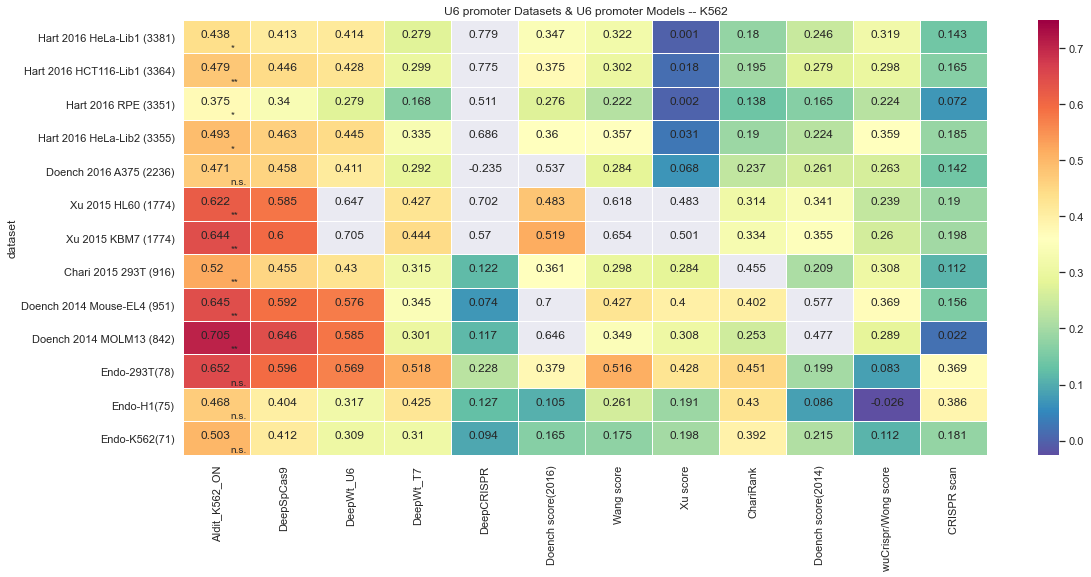

In [16]:
## 执行函数: For crispor data excluding gRNAs corresponding cell line
if __name__=='__main__':
    ## step 1: 汇集所有模型对 CRISPOR 的预测数据 
    #################################################### 
    ## CRISPOR Evaluation Data 数据整合 
    cell_line = 'K562'
    ## 汇集成字典数据 
    if cell_line == 'K562': 
        note_dataset_taining_model = note_dataset_taining_model_k562 
        parts_dataset_dict = {'U6 promoter': u6_datasets_for_comparison_k562, 
                             'T7 promoter': t7_datasets_for_comparison_k562, 
                             'small datasets': small_datasets_for_comparison_k562}
        update_dataset_dict = update_dataset_dict_k562
    elif cell_line == 'Jurkat':
        note_dataset_taining_model = note_dataset_taining_model_jurkat
        parts_dataset_dict = {'U6 promoter': u6_datasets_for_comparison_jurkat, 
                             'T7 promoter': t7_datasets_for_comparison_jurkat, 
                             'small datasets': small_datasets_for_comparison_jurkat}
        update_dataset_dict = update_dataset_dict_jurkat
    else: # elif cell_line == 'H1':
        note_dataset_taining_model = note_dataset_taining_model_h1
        parts_dataset_dict = {'U6 promoter': u6_datasets_for_comparison_h1, 
                             'T7 promoter': t7_datasets_for_comparison_h1, 
                             'small datasets': small_datasets_for_comparison_h1}
        update_dataset_dict = update_dataset_dict_h1
    ## read data 
    data_path = './On-Target/model_evaluation/CRISPOR_evaluation/spearman_correlation_for_on-target_tools-excluding_%s.xlsx'%(cell_line)
    df = pd.read_excel(data_path)
    df.rename(columns={'Jurkat_ypred': 'AIdit_Jurkat_ON', 
                       'H1_ypred': 'AIdit_H1_ON', 
                       'K562_ypred': 'AIdit_K562_ON'
                      }, inplace=True)
    ## 选择比较的模型 list                        
    selective_models_for_comparison = ['AIdit_%s_ON'%(cell_line), 
                                       'DeepSpCas9', 'DeepWt_U6', 'DeepWt_T7', 'DeepCRISPR', 
                                       'Doench score(2016)', 'Wang score', 'Xu score', 'ChariRank', 
                                       'Doench score(2014)', 'wuCrispr/Wong score', 'CRISPR scan']
    ## step 2: get heatmap data 
    paired_heatmap_data_dict = obtain_heatmap_data_for_models_comparison(df, parts_dataset_dict, 
                                                                         selective_models_for_comparison, 
                                                                         note_dataset_taining_model, 
                                                                         update_dataset_dict, cell_line)
    ## plot heatmap 
    ################################################################ 
    ## execute -- All 
    save_dir = './%s/on-target/Fig17-CRISPOR evaluation/filtered_crispor'%figsuplix
    mkdir(save_dir)
    sign_data_path = './On-Target/model_evaluation/CRISPOR_evaluation/Steiger_Test-%s vs the second best for CRISPOR.xlsx'%(cell_line)
    sign_data = pd.read_excel(sign_data_path)
    sign_data['Dataset'] = sign_data['Dataset'].apply(lambda x: update_dataset_dict[x] if x in update_dataset_dict else x)
    for object_way in ['U6 promoter']:
        ## 选择比较的模型
        data = paired_heatmap_data_dict[object_way][0]
        mask_data = paired_heatmap_data_dict[object_way][1]
        
        title = '%s Datasets & %s Models -- %s'%(object_way, object_way, cell_line)
        savefig_path = '%s/%s_comparison_for_crispor_excluding_%s.%s'%(save_dir, object_way, cell_line, figsuplix)
        ## For object_way == 'All'
        if object_way == 'All':
            plot_single_heatmap_for_comparison_adding_note_significant(data, mask_data, selective_models_for_comparison, 
                                                                       title, savefig_path, sign_data, 
                                             vmax=0.75, figsize=(30,15), cmap='Spectral_r')
        else:
            plot_single_heatmap_for_comparison_adding_note_significant(data, mask_data, selective_models_for_comparison, 
                                                                       title, savefig_path, sign_data, 
                                     vmax=0.75, figsize=(18, 8), cmap='Spectral_r')